## Machine Learning Final Project

Team Members:

- Hattie Lyons — Student ID: 00002070686  
- Lingjie Liao — Student ID: 00001688759 
- Adriana Esparza — Student ID: 00001530183 
- Zubair Zaki — Student ID: 00001764406 
- Mohammed Emaad Hazari - Student ID: 00001731092 


In [154]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import joblib

In [155]:
# Pulling cleaned data

X_scaled = joblib.load("X_scaled.pkl")
y = joblib.load("y.pkl")
feature_names = joblib.load("feature_names.pkl")

#### Train/Test Split

- We first split the dataset into 80% training and 20% testing.
The test set is held out early to avoid data leakage.
- stratify=y keeps the Benign/Attack ratio consistent, and random_state=42 makes the split reproducible.

⸻

#### Train–Validation Split

- From the 80% training portion, we take 20% to form a validation set (16% of the full dataset).
- This validation set is shared across all five models so their performance can be compared fairly.

In [156]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size = 0.2, # -- 80% training, 20% testing
    random_state = 42,
    stratify = y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (48800, 78)
Test set shape: (12201, 78)


In [157]:
# train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size = 0.2,      # 20% from 80% training →  16% of total
    random_state = 42,
    stratify = y_train
)

print("Train shape after splitting:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape after splitting: (39040, 78)
Validation shape: (9760, 78)
Test shape: (12201, 78)


##### Preparation for Model Evaluation
- `model_probs = {}` stores the predicted probabilities on the test set for each model.
- `results = []` stores the validation metrics (accuracy, precision, recall, and F1) for each model.
- Both variables are defined here so they can be updated easily inside the loop that evaluates all five models.

In [158]:
model_probs = {}
results = []

### Model 1: Random Forest

Random Forest is used as one of the classifiers in our comparison.  
It is a good candidate for this task because it is:

- Robust to noise and overfitting  
- Effective on high-dimensional tabular data (such as our 78-feature flow dataset)  
- Relatively easy to tune  
- Able to provide feature importance for interpretability

In [159]:
# Model 1: RandomForest Classifier 

# building model

rf_clf = RandomForestClassifier(
    n_estimators = 200, # n of trees
    max_depth = None,
    random_state = 42,
    n_jobs = -1 # use all cpu cores
)

# training model

rf_clf.fit(X_train, y_train)

print("RandomForest Classifier training completed.")

RandomForest Classifier training completed.


### Validation & Test Evaluation — Intro

To keep the notebook easy to read, this is the only place where we explain how the evaluation code works.  
The later sections will focus on discussing each model’s performance rather than repeating the same explanation.

**FYI:** The points below apply to all five models.

- We use the trained model to generate validation predictions (0 = benign, 1 = attack).  
- `predict_proba` gives the probability of being an attack instead of a hard 0/1 label.  
  This probability is needed for plotting the ROC and PR curves.
- **accuracy:** overall correctness  
- **precision:** among predicted attacks, how many are actually attacks (avoids false alarms)  
- **recall:** among all real attacks, how many the model detects (avoids missing attacks)  
- **F1 score:** the balance between precision and recall; often the key metric for classification  
- We store each model’s test-set probabilities in `model_probs[]` so we can later plot the ROC and PR curves for all five models at once.

#### RandomForest Classifier Comment：

The Random Forest model performs almost perfectly on both the validation and test sets, with almost no false positives or false negatives. This shows that it can reliably distinguish DoS attacks from normal traffic.

DoS attacks in the CIC-IDS2017 dataset have some very obvious patterns, such as unusually high traffic volume and special behavior patterns. Random Forest is good at handling many features at once and capturing complex relationships, which makes it especially suitable for this type of data.

This is also the main reason why it achieves such high scores.

In [160]:
# RandomForest Classifier  Validation Evaluation 
y_val_pred_rf = rf_clf.predict(X_val) # predicted labels
y_val_prob_rf = rf_clf.predict_proba(X_val)[:, 1] # probability for ATTCACK

rf_val_acc = accuracy_score(y_val, y_val_pred_rf)
rf_val_pre = precision_score(y_val, y_val_pred_rf)
rf_val_rec = recall_score(y_val, y_val_pred_rf)
rf_val_f1  = f1_score(y_val, y_val_pred_rf)

print("\nValidation Metrics (Random Forest):")
print("Accuracy :", rf_val_acc)
print("Precision:", rf_val_pre)
print("Recall   :", rf_val_rec)
print("F1 Score :", rf_val_f1)

# Test Evaluation
y_test_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
y_test_pred_rf = rf_clf.predict(X_test)

print("\nTest Metrics (Random Forest):")
print("Accuracy :", accuracy_score(y_test, y_test_pred_rf))
print("Precision:", precision_score(y_test, y_test_pred_rf))
print("Recall   :", recall_score(y_test, y_test_pred_rf))
print("F1 Score :", f1_score(y_test, y_test_pred_rf))

# Save for ROC/PR comparison later
model_probs["Random Forest"] = y_test_prob_rf


Validation Metrics (Random Forest):
Accuracy : 0.9993852459016394
Precision: 0.9994422132976349
Recall   : 0.9998883928571428
F1 Score : 0.999665253291676

Test Metrics (Random Forest):
Accuracy : 0.9995082370297517
Precision: 0.9996429846483399
Recall   : 0.9998214604534904
F1 Score : 0.9997322145853789


### Model 2: Logistic Regression

Logistic Regression tries to learn a linear decision boundary that separates Benign and Attack flows.  
During training, it adjusts its weights to reduce classification errors, so the model stays relatively simple compared to tree-based methods.

For this dataset, the default `max_iter=100` is sometimes not enough, and the model may fail to converge.  
To avoid this issue, we increase `max_iter` to 500 so the model has enough iterations to fully converge on the high-dimensional data.

In [161]:
# Model 2: Logistic Regression

# building model

lr_clf = LogisticRegression(max_iter=500)

# Train
lr_clf.fit(X_train, y_train)

print("Logistic Regression training completed.")

Logistic Regression training completed.


#### Logistic Regression Comment

The overall performance of Logistic Regression is decent, but it is clearly weaker than Random Forest.  
Since Logistic Regression is a linear model, it can only learn a straight-line decision boundary.

However, the DoS and benign traffic in the CIC-IDS2017 dataset often show more complex, non-linear patterns.  
Because of this, Logistic Regression may miss some important relationships between features, which leads to lower precision, recall, and F1 scores compared with the tree-based models.  
This outcome is expected for this type of data.

In [162]:
# Validation Evaluation 
y_val_pred_lr = lr_clf.predict(X_val)
y_val_prob_lr = lr_clf.predict_proba(X_val)[:, 1]

lr_val_acc = accuracy_score(y_val, y_val_pred_lr)
lr_val_pre = precision_score(y_val, y_val_pred_lr)
lr_val_rec = recall_score(y_val, y_val_pred_lr)
lr_val_f1  = f1_score(y_val, y_val_pred_lr)

print("\nValidation Metrics (Logistic Regression):")
print("Accuracy :", lr_val_acc)
print("Precision:", lr_val_pre)
print("Recall   :", lr_val_rec)
print("F1 Score :", lr_val_f1)

# Test Evaluation 
y_test_prob_lr = lr_clf.predict_proba(X_test)[:, 1]
y_test_pred_lr = lr_clf.predict(X_test)

print("\nTest Metrics (Logistic Regression):")
print("Accuracy :", accuracy_score(y_test, y_test_pred_lr))
print("Precision:", precision_score(y_test, y_test_pred_lr))
print("Recall   :", recall_score(y_test, y_test_pred_lr))
print("F1 Score :", f1_score(y_test, y_test_pred_lr))

# Save for global ROC/PR comparison later
model_probs["Logistic Regression"] = y_test_prob_lr


Validation Metrics (Logistic Regression):
Accuracy : 0.9923155737704918
Precision: 0.9921347069901407
Recall   : 0.9995535714285714
F1 Score : 0.9958303218991494

Test Metrics (Logistic Regression):
Accuracy : 0.9928694369313991
Precision: 0.9924678777137793
Recall   : 0.9998214604534904
F1 Score : 0.9961310979677147


### Model 3: Decision Tree

A Decision Tree makes predictions by repeatedly splitting the data based on feature thresholds.
Each split tries to separate Benign and Attack flows into purer groups, forming a tree-like structure that leads to a final decision.

Decision Trees are easy to interpret and can naturally capture non-linear patterns in the data.
We also set a `random_state=42` to ensure reproducible results across different runs.

In [163]:
# Model 3: Decision Tree

# building model

dt_clf = DecisionTreeClassifier(random_state=42)

# Train
dt_clf.fit(X_train, y_train)

print("Decision Tree training completed.")



Decision Tree training completed.


#### Decision Tree Comment:

Although the Decision Tree also scores very high, it only uses a single tree, so in theory it is more sensitive to noise compared to Random Forest.  
In this task its performance is still strong, but Random Forest is generally more stable because it combines the results of many trees.  
This usually gives it better generalization ability.

In [164]:
# Validation Evaluation
y_val_pred_dt = dt_clf.predict(X_val)
y_val_prob_dt = dt_clf.predict_proba(X_val)[:, 1]

dt_val_acc = accuracy_score(y_val, y_val_pred_dt)
dt_val_pre = precision_score(y_val, y_val_pred_dt)
dt_val_rec = recall_score(y_val, y_val_pred_dt)
dt_val_f1  = f1_score(y_val, y_val_pred_dt)

print("\nValidation Metrics (Decision Tree):")
print("Accuracy :", dt_val_acc)
print("Precision:", dt_val_pre)
print("Recall   :", dt_val_rec)
print("F1 Score :", dt_val_f1)

# Test Evaluation
y_test_prob_dt = dt_clf.predict_proba(X_test)[:, 1]
y_test_pred_dt = dt_clf.predict(X_test)

print("\nTest Metrics (Decision Tree):")
print("Accuracy :", accuracy_score(y_test, y_test_pred_dt))
print("Precision:", precision_score(y_test, y_test_pred_dt))
print("Recall   :", recall_score(y_test, y_test_pred_dt))
print("F1 Score :", f1_score(y_test, y_test_pred_dt))

# Save for global ROC/PR comparison later
model_probs["Decision Tree"] = y_test_prob_dt


Validation Metrics (Decision Tree):
Accuracy : 0.9991803278688525
Precision: 0.999330655957162
Recall   : 0.9997767857142857
F1 Score : 0.9995536710555679

Test Metrics (Decision Tree):
Accuracy : 0.9995901975247931
Precision: 0.9997322145853789
Recall   : 0.9998214604534904
F1 Score : 0.999776835527784


### Model 4: SVM (RBF Kernel)

Support Vector Machines classify data by finding the best boundary that separates the two classes.
With the RBF kernel, SVM can capture non-linear patterns by mapping the data into a higher-dimensional space before making the decision.

We enable `probability=True` so the model can output class probabilities, which are required later for ROC and PR curve evaluation.
SVM can be computationally heavier on large datasets, but it is still a strong baseline for non-linear classification tasks.

In [165]:
# Model 4: SVM (RBF Kernel)

# building model

svm_clf = SVC(kernel='rbf', probability=True)

# Train
svm_clf.fit(X_train, y_train)

print("SVM training completed.")

SVM training completed.


#### SVM Comment:

SVM also performs quite well, with its F1 score staying around 99%, showing that it can capture the main patterns of DoS attacks.  
However, SVM can be computationally heavy on high-dimensional data like this, and it isn’t as good as tree-based models at handling complex feature interactions.  
Its recall is very high, but the precision is slightly lower, so overall the performance is solid but not as close to perfect as RF or GBDT.

In [166]:
# Validation Evaluation
y_val_pred_svm = svm_clf.predict(X_val)
y_val_prob_svm = svm_clf.predict_proba(X_val)[:, 1]

svm_val_acc = accuracy_score(y_val, y_val_pred_svm)
svm_val_pre = precision_score(y_val, y_val_pred_svm)
svm_val_rec = recall_score(y_val, y_val_pred_svm)
svm_val_f1  = f1_score(y_val, y_val_pred_svm)

print("\nValidation Metrics (SVM):")
print("Accuracy :", svm_val_acc)
print("Precision:", svm_val_pre)
print("Recall   :", svm_val_rec)
print("F1 Score :", svm_val_f1)

# Test Evaluation
y_test_prob_svm = svm_clf.predict_proba(X_test)[:, 1]
y_test_pred_svm = svm_clf.predict(X_test)

print("\nTest Metrics (SVM):")
print("Accuracy :", accuracy_score(y_test, y_test_pred_svm))
print("Precision:", precision_score(y_test, y_test_pred_svm))
print("Recall   :", recall_score(y_test, y_test_pred_svm))
print("F1 Score :", f1_score(y_test, y_test_pred_svm))

# Save for ROC/PR comparison
model_probs["SVM (RBF)"] = y_test_prob_svm


Validation Metrics (SVM):
Accuracy : 0.9934426229508196
Precision: 0.9932357507207806
Recall   : 0.9996651785714286
F1 Score : 0.996440093447547

Test Metrics (SVM):
Accuracy : 0.9942627653471027
Precision: 0.9943161634103019
Recall   : 0.9994643813604713
F1 Score : 0.9968836256789244


### Model 5: Gradient Boosting

Gradient Boosting builds an ensemble of decision trees sequentially, where each new tree focuses on correcting the errors made by the previous ones.
This step-by-step learning process allows the model to capture complex patterns and interactions between features.

We use the default settings of `GradientBoostingClassifier()` since it already provides strong performance on structured, tabular datasets like this one.

In [167]:
# Model 5: Gradient Boosting

# building model

gb_clf = GradientBoostingClassifier()

# Train
gb_clf.fit(X_train, y_train)

print("Gradient Boosting training completed.")



Gradient Boosting training completed.


#### Gradient Boosting Comment:

Gradient Boosting also achieves very high scores, which shows that it fits this type of DoS data really well.  
Since the model learns by gradually correcting the errors made in previous steps, it handles complex feature relationships effectively.  
Its performance is just slightly lower than Random Forest, but overall it is still very close to top-level accuracy.

In [168]:
# Validation Evaluation
y_val_pred_gb = gb_clf.predict(X_val)
y_val_prob_gb = gb_clf.predict_proba(X_val)[:, 1]

gb_val_acc = accuracy_score(y_val, y_val_pred_gb)
gb_val_pre = precision_score(y_val, y_val_pred_gb)
gb_val_rec = recall_score(y_val, y_val_pred_gb)
gb_val_f1  = f1_score(y_val, y_val_pred_gb)

print("\nValidation Metrics (Gradient Boosting):")
print("Accuracy :", gb_val_acc)
print("Precision:", gb_val_pre)
print("Recall   :", gb_val_rec)
print("F1 Score :", gb_val_f1)

# Test Evaluation
y_test_prob_gb = gb_clf.predict_proba(X_test)[:, 1]
y_test_pred_gb = gb_clf.predict(X_test)

print("\nTest Metrics (Gradient Boosting):")
print("Accuracy :", accuracy_score(y_test, y_test_pred_gb))
print("Precision:", precision_score(y_test, y_test_pred_gb))
print("Recall   :", recall_score(y_test, y_test_pred_gb))
print("F1 Score :", f1_score(y_test, y_test_pred_gb))

# Save for ROC/PR comparison later
model_probs["Gradient Boosting"] = y_test_prob_gb


Validation Metrics (Gradient Boosting):
Accuracy : 0.9987704918032787
Precision: 0.998773690078038
Recall   : 0.9998883928571428
F1 Score : 0.9993307306190742

Test Metrics (Gradient Boosting):
Accuracy : 0.9993443160396689
Precision: 0.9993754461099215
Recall   : 0.9999107302267453
F1 Score : 0.9996430165104864


### Conclusion:

Overall, Random Forest has the highest scores across all four metrics, making it the most stable and strongest model.  
Decision Tree and Gradient Boosting also perform very well and are close behind, which shows that tree-based models in general fit this DoS dataset really well.

SVM and Logistic Regression also reach around 99%, but they handle complex feature relationships less effectively than the tree models, so their F1 scores are slightly lower.  
In summary, tree-based models work best for this task, with Random Forest standing out as the top performer.

In [169]:
# Unified Validation Metrics Comparison (5 Models)

results = []

results.append([
    "Random Forest",
    rf_val_acc, rf_val_pre, rf_val_rec, rf_val_f1
])

results.append([
    "Logistic Regression",
    lr_val_acc, lr_val_pre, lr_val_rec, lr_val_f1
])

results.append([
    "Decision Tree",
    dt_val_acc, dt_val_pre, dt_val_rec, dt_val_f1
])

results.append([
    "SVM (RBF)",
    svm_val_acc, svm_val_pre, svm_val_rec, svm_val_f1
])

results.append([
    "Gradient Boosting",
    gb_val_acc, gb_val_pre, gb_val_rec, gb_val_f1
])

# Convert to DataFrame
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
)

# Sort by F1 Score
results_df = results_df.sort_values(by="F1 Score", ascending=False)

results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.999385,0.999442,0.999888,0.999665
2,Decision Tree,0.999180,0.999331,0.999777,0.999554
4,Gradient Boosting,0.998770,0.998774,0.999888,0.999331
3,SVM (RBF),0.993443,0.993236,0.999665,0.996440
1,Logistic Regression,0.992316,0.992135,0.999554,0.995830


### ROC：

The ROC curves show that all five models perform well above the diagonal, meaning they all have strong classification ability.
Tree-based models stay closer to the top-left corner, indicating more stable performance across different thresholds.
LR and SVM shift slightly to the right, so their stability is a bit weaker.
Overall, the ROC plot gives a clear visual confirmation of each model’s classification quality.

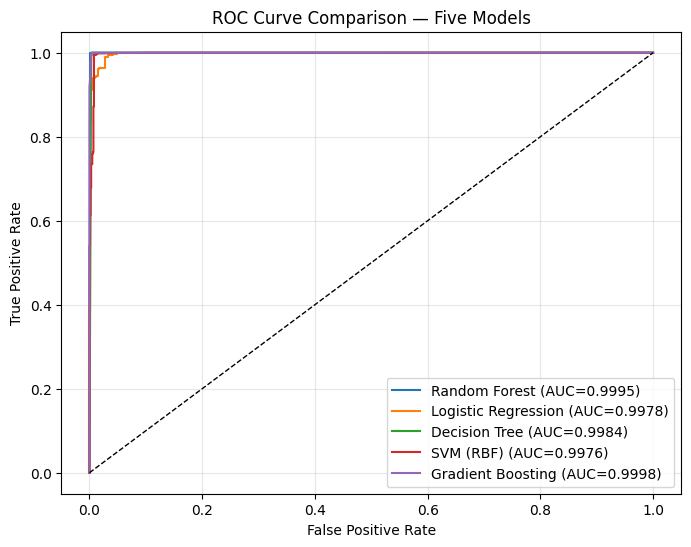

In [170]:
# ROC Curve Comparison (5 models)

plt.figure(figsize=(8, 6))

for model_name, y_prob in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.4f})")

# Baseline line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison — Five Models")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

### Precision–Recall Curve

The PR curve focuses on whether the model produces false alarms while trying to catch as many attacks as possible.  
From the plot, all five models maintain very high Precision even when Recall is close to 1.

The tree-based models have the flattest curves, almost like a straight line, showing that they stay stable regardless of the threshold.  
LR and SVM drop slightly, but their overall performance remains strong.

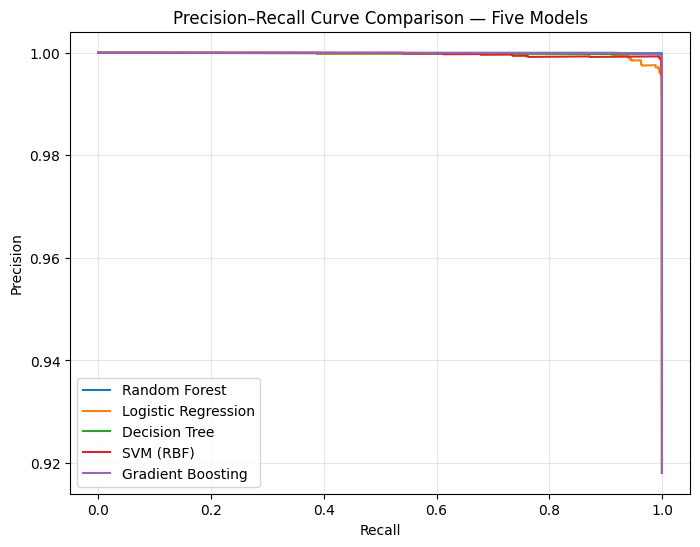

In [171]:
# Precision-Recall Curve Comparison (5 models)

plt.figure(figsize=(8, 6))

for model_name, y_prob in model_probs.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=model_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison — Five Models")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

### AUC

The AUC ranking shows that the tree-based models maintain the most stable discrimination across different thresholds.  
Gradient Boosting performs the best, followed by Random Forest.

In [172]:
# AUC Comparison Table (Test Set)

auc_results = []

for model_name, y_prob in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    auc_results.append([model_name, roc_auc])

# Make DataFrame
auc_df = pd.DataFrame(auc_results, columns=["Model", "AUC"])
auc_df = auc_df.sort_values(by="AUC", ascending=False)

auc_df

,Model,AUC
4,Gradient Boosting,0.999842
0,Random Forest,0.999486
2,Decision Tree,0.998409
1,Logistic Regression,0.997764
3,SVM (RBF),0.997605


## Best Model: Random Forest

Since Random Forest had the best results, we also looked at its performance separately.
The ROC and PR curves are almost perfect, showing that the model stays very stable no matter how the threshold changes.

In [175]:
# Final Model Deep Evaluation: Random Forest

print("Final Model: Random Forest — Detailed Evaluation\n")

print("Accuracy: {:.4f}".format(acc))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["BENIGN", "ATTACK"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Final Model: Random Forest — Detailed Evaluation

Accuracy: 0.9995

Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       999
      ATTACK       1.00      1.00      1.00     11202

    accuracy                           1.00     12201
   macro avg       1.00      1.00      1.00     12201
weighted avg       1.00      1.00      1.00     12201

Confusion Matrix:
[[  995     4]
 [    2 11200]]


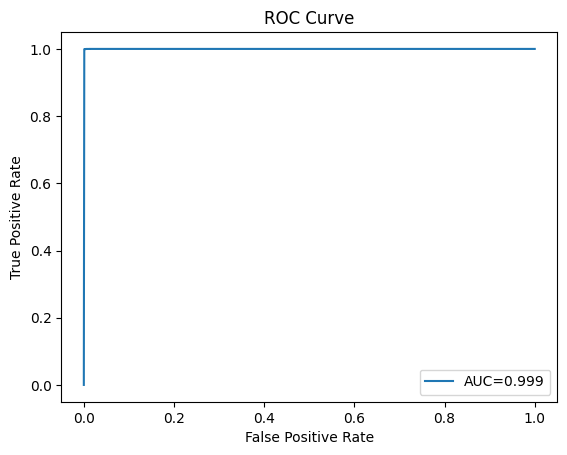

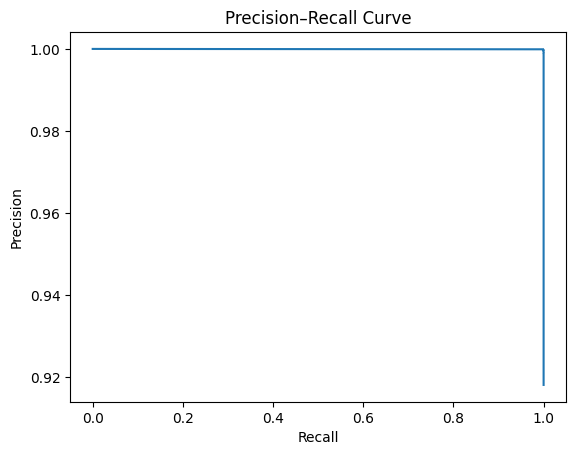

In [174]:
# Best Model eval 
# ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()